In [46]:
import os
os.environ['KAGGLE_CONFIG_DIR']= '/content'

In [47]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [48]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

fruit-and-vegetable-image-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [49]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fruit-and-vegetable-image-recognition.zip', 'r')
zip_ref.extractall('/content/fruit-vegetables')
zip_ref.close()

In [50]:
!pip install tensorflow_addons

In [51]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2, ResNet101V2, ResNet152V2, InceptionResNetV2,MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

import numpy as np
from pathlib import Path
import tensorflow as tf
import pandas as pd

In [52]:
# Create a list with the filepaths for training and testing
train_dir = Path('/content/fruit-vegetables/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/fruit-vegetables/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/content/fruit-vegetables/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [53]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [54]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['jalepeno' 'spinach' 'orange' 'peas' 'pear' 'lettuce' 'carrot' 'lemon'
 'kiwi' 'cucumber' 'mango' 'eggplant' 'cabbage' 'chilli pepper'
 'pineapple' 'tomato' 'apple' 'soy beans' 'cauliflower' 'raddish'
 'sweetpotato' 'grapes' 'onion' 'garlic' 'watermelon' 'turnip'
 'pomegranate' 'ginger' 'capsicum' 'corn' 'banana' 'potato' 'bell pepper'
 'paprika' 'sweetcorn' 'beetroot']


In [55]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)


,Filepath,Label
0,/content/fruit-vegetables/train/jalepeno/Image...,jalepeno
1,/content/fruit-vegetables/train/jalepeno/Image...,jalepeno
2,/content/fruit-vegetables/train/spinach/Image_...,spinach
3,/content/fruit-vegetables/train/orange/Image_6...,orange
4,/content/fruit-vegetables/train/peas/Image_35.jpg,peas


In [56]:
unique_labels = train_df.copy().drop_duplicates(subset=['Label']).reset_index()
train_df['Label'].nunique()

36

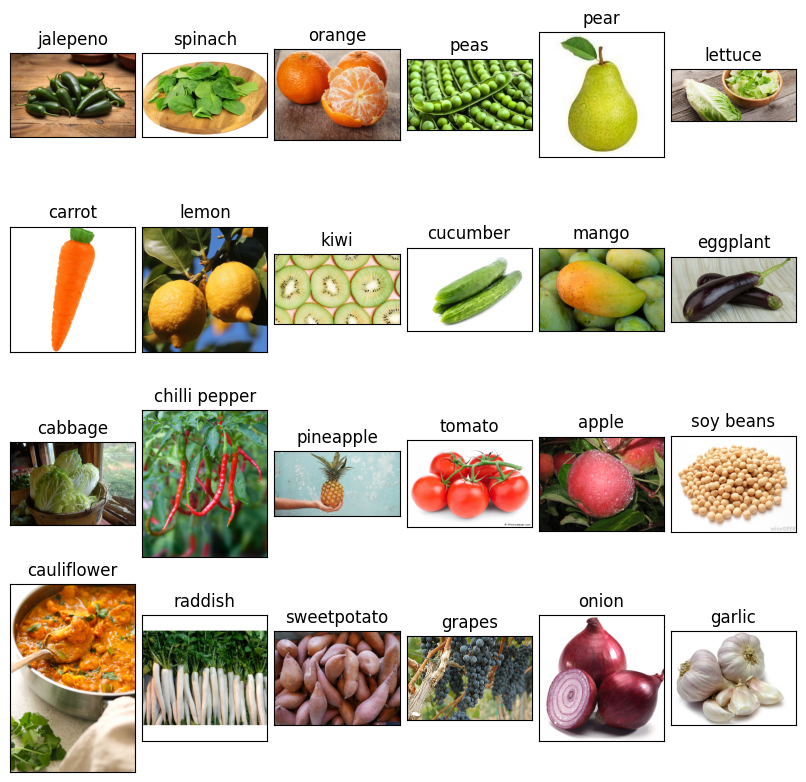

In [57]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(unique_labels.Filepath[i]))
    ax.set_title(unique_labels.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [61]:
train_generator = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [62]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
base_model.trainable = False

In [65]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [66]:
# Add custom classification head
x = base_model.output

x = Dense(128, activation="relu")(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(36, activation="softmax")(x)


In [67]:
model = Model(inputs=base_model.input, outputs=predictions)

In [68]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [70]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])



In [71]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)


In [72]:
# Define the number of epochs, steps, and early stopping
num_epochs = 5
steps_per_epoch = len(train_images)
validation_steps = len(val_images)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_images,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_images,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/5
87/87 [==============================] - 257s 3s/step - loss: 1.7385 - accuracy: 0.5572 - val_loss: 0.4374 - val_accuracy: 0.8743
Epoch 2/5
87/87 [==============================] - 265s 3s/step - loss: 0.5721 - accuracy: 0.8187 - val_loss: 0.2728 - val_accuracy: 0.9192
Epoch 3/5
87/87 [==============================] - 246s 3s/step - loss: 0.3376 - accuracy: 0.8878 - val_loss: 0.2521 - val_accuracy: 0.9281
Epoch 4/5
87/87 [==============================] - 243s 3s/step - loss: 0.2296 - accuracy: 0.9237 - val_loss: 0.1998 - val_accuracy: 0.9551
Epoch 5/5
87/87 [==============================] - 248s 3s/step - loss: 0.1668 - accuracy: 0.9424 - val_loss: 0.1878 - val_accuracy: 0.9461


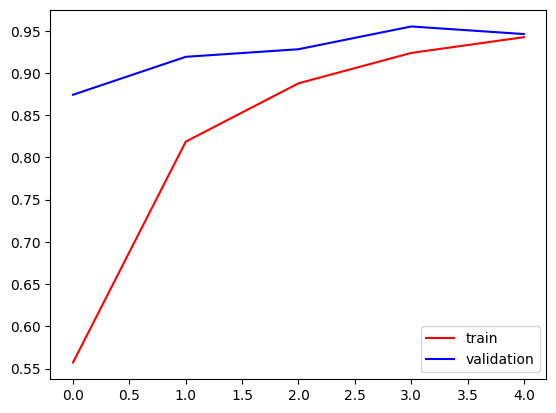

In [74]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

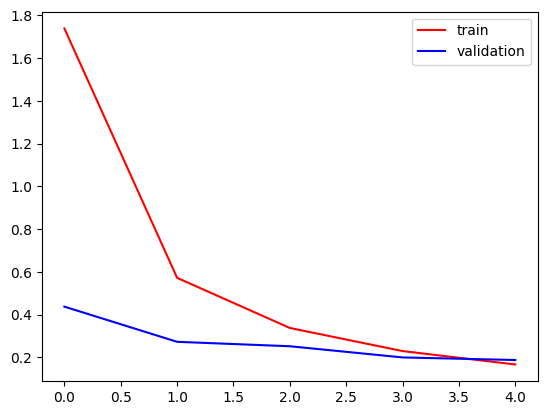

In [84]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [81]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Map the numeric labels to their corresponding class names
label_mapping = {v: k for k, v in train_images.class_indices.items()}
predicted_classes = [label_mapping[label] for label in predicted_labels]

# Map the true labels of the test set
true_labels = [label_mapping[label] for label in test_images.classes]

# Print a few sample predictions and true labels
for i in range(10):
    print(f"Predicted: {predicted_classes[i]}, True: {true_labels[i]}")

11/11 [==============================] - 25s 2s/step
Predicted: onion, True: onion
Predicted: sweetcorn, True: sweetcorn
Predicted: pear, True: pear
Predicted: lettuce, True: lettuce
Predicted: raddish, True: raddish
Predicted: watermelon, True: watermelon
Predicted: beetroot, True: beetroot
Predicted: watermelon, True: watermelon
Predicted: paprika, True: paprika
Predicted: ginger, True: ginger


In [82]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 94.61%


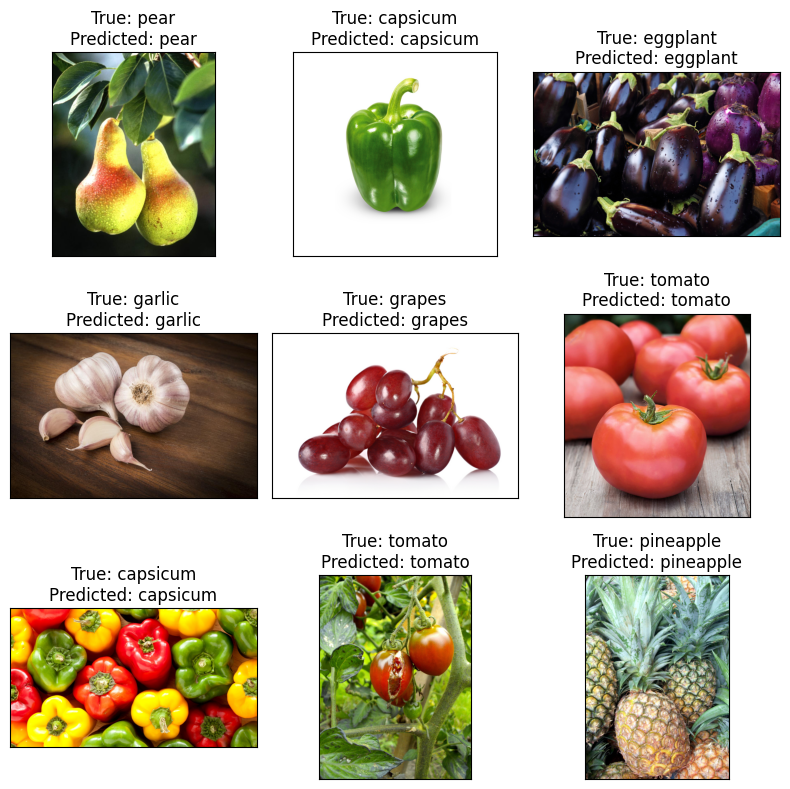

In [85]:
import matplotlib.pyplot as plt

# Select a few random test samples for display
sample_indices = np.random.choice(len(test_df), size=9, replace=False)
sample_images = [plt.imread(test_df.Filepath.iloc[i]) for i in sample_indices]
sample_labels = [f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}" for i in sample_indices]

# Display the sample images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, img, label in zip(axes.flat, sample_images, sample_labels):
    ax.imshow(img)
    ax.set_title(label)

plt.tight_layout()
plt.show()